In [1]:
%matplotlib inline 
import sys
import os,shutil,datetime
import numpy as np
import math
import random
import string
import subprocess
import pickle
import matplotlib.pylab as plt
import scipy.sparse as sps
from molSimplify.Classes import globalvars
from molSimplify.Classes import mol3D
from molSimplify.Scripts.molSimplify_io import *
import time
from molSimplify.Informatics.autocorrelation import*
from molSimplify.Informatics.misc_descriptors import*
from molSimplify.Informatics.RACassemble import*
from molSimplify.Informatics.graph_analyze import*
from molSimplifyAD.ga_tools import * 


######################################################################################################################
# This notebook takes a ligand space and returns a set of RACs corresponding to all complexes that populate that     #
# space with a given symmetry. This code needs to be adjusted if the RACs need to be enumerated for other symmetries.#
######################################################################################################################


In [25]:
# This function mmakees the ligand class that is needed for geo free RACs
def make_ligand_from_name(name):
    this_mol, emsg = lig_load(name)
    this_mol.convert2mol3D()
    this_lig  = ligand(mol3D(), [],this_mol.denticity)
    this_lig.mol = this_mol
    conatoms = this_mol.cat
    return(this_lig,conatoms)

# Takes a SMILES string and makes the ligand class based on the denticity
def SMILEs_to_liglist(smiles, denticity):
    this_mol = mol3D()
    this_mol.getOBMol(smiles,'smistring')
    this_mol.convert2mol3D()
    this_lig  = ligand(mol3D(), [], denticity)
    this_lig.mol = this_mol
    return(this_lig)

# Takes an equatorial ligand, and (ax1,ax2) ligands
def make_ligand_dictionary_from_ligands(eq,ax1,ax2,eqcon,ax1con,ax2con):
    # CURRENTLY THERE IS NOT HANDLING FOR TRIPLE BIDENTATES!!!!
    # count number of equatorial ligands. Only one if denticity is 4.
    eq_number = int(4/eq.dent)
    eq_cons = eq_number*[eqcon] # Sets the connecting atom list
    eq_ligs = eq_number*[eq] # Sets the list of ligands equatorially
    ax_ligs = [ax1,ax2]
    ax_cons = [ax1con,ax2con]
    custom_ligand_dict = {"eq_ligand_list":eq_ligs,
                      "ax_ligand_list":ax_ligs,
                      "eq_con_int_list":eq_cons,
                      "ax_con_int_list":ax_cons}
    return(custom_ligand_dict)


def get_run_from_index(h,i,j,k,metals,lignames,ligs,cons,ox,spin):
    
    this_metal = metals[h]
    this_ox = ox
    
    eq_name = lignames[i]
    ax1_name = lignames[j]
    ax2_name = lignames[k]

    eq_lig = ligs[i]
    ax1_lig = ligs[j]
    ax2_lig = ligs[k]

    eq_cons = cons[i]
    ax1_cons = cons[j]
    ax2_cons = cons[k]

    ## name complex
    this_name = "_".join([str(this_metal),str(this_ox),str(spin),eq_name,eq_name,eq_name,eq_name,ax1_name,ax2_name])

    metal_mol = mol3D()
    metal_mol.addAtom(atom3D(this_metal.capitalize())) 

    ## assemble ligands
    custom_ligand_dict = make_ligand_dictionary_from_ligands(eq_lig,ax1_lig,ax2_lig,eq_cons,ax1_cons,ax2_cons)
    ## make complex -
    this_complex = assemble_connectivity_from_parts(metal_mol,custom_ligand_dict)

    ## get features
    descriptor_names, descriptors = get_descriptor_vector(this_complex,custom_ligand_dict)
    descriptor_names.append('ox')
    descriptors.append(this_ox)
    descriptor_names.append('spin')
    descriptors.append(spin)
    descriptor_names = [val[0] if isinstance(val,list) else val for val in descriptor_names]
    descriptors = [val[0] if isinstance(val,list) else val for val in descriptors] #flatten lists
    RAC_dict = dict(zip(descriptor_names, descriptors))

    ## store results in dictionary
    RAC_dict['name'] = this_name
    return RAC_dict


In [41]:
lignames = ['ammonia','water','carbonyl','misc','acetonitrile','pyridine','bipy','porphyrin','acac','pyrrole']
metals = ["cr","mn","fe","co"]
spin_dict = {'co': {2: [2, 4], 3: [1, 3, 5], 4: [2, 4], 5: [1, 3, 5]},
             'cr': {2: [1, 3, 5], 3: [2, 4], 4: [1, 3], 5: [2]},
             'fe': {2: [1, 3, 5], 3: [2, 4, 6], 4: [1, 3, 5], 5: [2, 4]},
             'mn': {2: [2, 4, 6], 3: [1, 3, 5], 4: [2, 4], 5: [1, 3]},
             'rh': {2: [2, 4], 3: [1, 3, 5], 4: [2, 4], 5: [1, 3, 5]},
             'mo': {2: [1, 3, 5], 3: [2, 4], 4: [1, 3], 5: [2]},
             'ru': {2: [1, 3, 5], 3: [2, 4, 6], 4: [1, 3, 5], 5: [2, 4]},
             'tc': {2: [2, 4, 6], 3: [1, 3, 5], 4: [2, 4], 5: [1, 3]}}

ligs  = []
cons  = []
mono_inds = []
bi_inds = []
tet_inds  = []
for ii,name in enumerate(lignames):    
    this_lig, this_con = make_ligand_from_name(name)
    ligs.append(this_lig)
    cons.append(this_con)
    if len(this_con) == 1:
        mono_inds.append(ii)
    elif len(this_con) == 2:
        bi_inds.append(ii)
    elif len(this_con) == 4:
        tet_inds.append(ii)
    

loading ligand from dictionary: ammonia
looking for /Users/adityanandy/Desktop/molSimplify/molSimplify//Ligands/ammonia.mol
loading ligand from dictionary: water
looking for /Users/adityanandy/Desktop/molSimplify/molSimplify//Ligands/water.mol
loading ligand from dictionary: carbonyl
looking for /Users/adityanandy/Desktop/molSimplify/molSimplify//Ligands/carbonyl.mol
loading ligand from dictionary: misc
looking for /Users/adityanandy/Desktop/molSimplify/molSimplify//Ligands/methylisocy.mol
loading ligand from dictionary: acetonitrile
looking for /Users/adityanandy/Desktop/molSimplify/molSimplify//Ligands/acetonitrile.mol
loading ligand from dictionary: pyridine
looking for /Users/adityanandy/Desktop/molSimplify/molSimplify//Ligands/pyridine.mol
loading ligand from dictionary: bipy
looking for /Users/adityanandy/Desktop/molSimplify/molSimplify//Ligands/bipy.mol
loading ligand from dictionary: porphyrin
looking for /Users/adityanandy/Desktop/molSimplify/molSimplify//Ligands/porphyrin.mol

In [42]:
print('found ' + str(len(mono_inds)) + ' monodentates' )
print('found ' + str(len(bi_inds)) + ' bidentates' )
print('found ' + str(len(tet_inds)) + ' tetradentates' )

found 7 monodentates
found 2 bidentates
found 1 tetradentates


In [43]:
## make homoleptic monodentates
run_list = []
count = 0
start_time = time.time()
tag = 'HO'
for h in range(0,len(metals)):
    for ox in [2, 3]:
        for spin in spin_dict[metals[h]][ox]:
            for ind in mono_inds:
                RAC_dict = get_run_from_index(h=h,i=ind,j=ind,k=ind,metals=metals,
                                                 lignames=lignames,ligs=ligs,cons=cons,ox=ox,spin=spin)
                RAC_dict['tag'] = tag
                count += 1
                run_list.append(RAC_dict)
new_time = (time.time() - start_time)
print('made ' + str(count) +  ' homoeleptics in '+"--- %s seconds ---" % new_time )
print('for an average time of '+"--- %s seconds ---" % str(new_time/count) )


made 154 homoeleptics in --- 13.940882206 seconds ---
for an average time of --- 0.0905252091296 seconds ---


In [44]:
## make cis-axial-heteroleptic species
count = 0
tag = "CA"
start_time = time.time()
for h in range(0,len(metals)):
    for ox in [2, 3]:
        for spin in spin_dict[metals[h]][ox]:
            for eq_ind in mono_inds+bi_inds+tet_inds:
                for ax_ind in mono_inds: # axial ligands can only be monodentate
                    if not ax_ind == eq_ind: # make sure that homoleptics don't get repeated
                        RAC_dict = get_run_from_index(h=h,i=eq_ind,j=ax_ind,k=ax_ind,metals=metals,
                                                     lignames=lignames,ligs=ligs,cons=cons,ox=ox,spin=spin)
                        RAC_dict['tag'] = tag
                        count += 1
                        run_list.append(RAC_dict)

new_time = (time.time() - start_time)
print('made ' + str(count) +  ' cis-axial-heteroleptics in '+"--- %s seconds ---" % new_time)
print('for an average time of '+"--- %s seconds ---" % str(new_time/count) )

made 1386 cis-axial-heteroleptics in --- 124.072400808 seconds ---
for an average time of --- 0.0895183267015 seconds ---


In [45]:
## make trans-axial-hetros
count = 0
tag = "TA"
start_time = time.time()
for h in range(0,len(metals)):
    for ox in [2, 3]:
        for spin in spin_dict[metals[h]][ox]:
            for eq_ind in mono_inds+bi_inds+tet_inds:
                for ax1_ind in mono_inds:
                    for ax2_ind in mono_inds:
                        if ax1_ind > ax2_ind: #This makes sure that isomers in diff positions are not repeated
                            RAC_dict = get_run_from_index(h=h,i=eq_ind,j=ax1_ind,k=ax2_ind,metals=metals,
                                                             lignames=lignames,ligs=ligs,cons=cons,ox=ox,spin=spin)
                            RAC_dict['tag'] = tag
                            count += 1
                            run_list.append(RAC_dict)
new_time = (time.time() - start_time)
print('made ' + str(count) +  ' trans-axial-heteroleeptic in '+"--- %s seconds ---" % new_time)
print('for an average time of '+"--- %s seconds ---" % str(new_time/count) )

made 4620 trans-axial-heteroleeptic in --- 428.233638048 seconds ---
for an average time of --- 0.0926912636468 seconds ---


In [46]:
df = pd.DataFrame(run_list) # turns list of complexes into a df

In [49]:
df

,D_lc-I-0-ax,D_lc-I-0-eq,D_lc-I-1-ax,D_lc-I-1-eq,D_lc-I-2-ax,D_lc-I-2-eq,D_lc-I-3-ax,D_lc-I-3-eq,D_lc-S-0-ax,D_lc-S-0-eq,...,mc-chi-2-all,mc-chi-3-all,misc-charge-ax,misc-charge-eq,misc-dent-ax,misc-dent-eq,name,ox,spin,tag
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,65.7360,0.000,0.0,0.0,1.0,1.0,cr_2_1_ammonia_ammonia_ammonia_ammonia_ammonia...,2,1,HO
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,43.8240,0.000,0.0,0.0,1.0,1.0,cr_2_1_water_water_water_water_water_water,2,1,HO
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,34.2624,0.000,0.0,0.0,1.0,1.0,cr_2_1_carbonyl_carbonyl_carbonyl_carbonyl_car...,2,1,HO
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30.2784,25.398,0.0,0.0,1.0,1.0,cr_2_1_misc_misc_misc_misc_misc_misc,2,1,HO
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.3980,25.398,0.0,0.0,1.0,1.0,cr_2_1_acetonitrile_acetonitrile_acetonitrile_...,2,1,HO
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50.7960,94.620,0.0,0.0,1.0,1.0,cr_2_1_pyridine_pyridine_pyridine_pyridine_pyr...,2,1,HO
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50.7960,94.620,0.0,0.0,1.0,1.0,cr_2_1_pyrrole_pyrrole_pyrrole_pyrrole_pyrrole...,2,1,HO
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,65.7360,0.000,0.0,0.0,1.0,1.0,cr_2_3_ammonia_ammonia_ammonia_ammonia_ammonia...,2,3,HO
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,43.8240,0.000,0.0,0.0,1.0,1.0,cr_2_3_water_water_water_water_water_water,2,3,HO
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,34.2624,0.000,0.0,0.0,1.0,1.0,cr_2_3_carbonyl_carbonyl_carbonyl_carbonyl_car...,2,3,HO


In [50]:
dropped = df.loc[:, (df != df.iloc[0]).any()] # This drops the constant RACs

In [51]:
dropped

,D_lc-S-1-ax,D_lc-S-1-eq,D_lc-S-2-ax,D_lc-S-2-eq,D_lc-S-3-ax,D_lc-S-3-eq,D_lc-T-1-ax,D_lc-T-1-eq,D_lc-T-2-ax,D_lc-T-2-eq,...,mc-Z-3-all,mc-chi-0-all,mc-chi-1-all,mc-chi-2-all,mc-chi-3-all,misc-dent-eq,name,ox,spin,tag
0,1.14,1.14,0.00,0.00,0.00,0.00,6.0,6.0,0.0,0.0,...,0.0,2.7556,30.2784,65.7360,0.000,1.0,cr_2_1_ammonia_ammonia_ammonia_ammonia_ammonia...,2,1,HO
1,0.72,0.72,0.00,0.00,0.00,0.00,2.0,2.0,0.0,0.0,...,0.0,2.7556,34.2624,43.8240,0.000,1.0,cr_2_1_water_water_water_water_water_water,2,1,HO
2,0.04,0.04,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,2.7556,25.3980,34.2624,0.000,1.0,cr_2_1_carbonyl_carbonyl_carbonyl_carbonyl_car...,2,1,HO
3,0.02,0.02,0.00,0.00,1.20,1.20,-1.0,-1.0,-3.0,-3.0,...,864.0,2.7556,25.3980,30.2784,25.398,1.0,cr_2_1_misc_misc_misc_misc_misc_misc,2,1,HO
4,-0.02,-0.02,-0.02,-0.02,1.14,1.14,-1.0,-1.0,-3.0,-3.0,...,864.0,2.7556,30.2784,25.3980,25.398,1.0,cr_2_1_acetonitrile_acetonitrile_acetonitrile_...,2,1,HO
5,-0.04,-0.04,0.72,0.72,0.74,0.74,-2.0,-2.0,0.0,0.0,...,2016.0,2.7556,30.2784,50.7960,94.620,1.0,cr_2_1_pyridine_pyridine_pyridine_pyridine_pyr...,2,1,HO
6,-0.04,-0.04,0.72,0.72,0.76,0.76,-2.0,-2.0,0.0,0.0,...,2016.0,2.7556,30.2784,50.7960,94.620,1.0,cr_2_1_pyrrole_pyrrole_pyrrole_pyrrole_pyrrole...,2,1,HO
7,1.14,1.14,0.00,0.00,0.00,0.00,6.0,6.0,0.0,0.0,...,0.0,2.7556,30.2784,65.7360,0.000,1.0,cr_2_3_ammonia_ammonia_ammonia_ammonia_ammonia...,2,3,HO
8,0.72,0.72,0.00,0.00,0.00,0.00,2.0,2.0,0.0,0.0,...,0.0,2.7556,34.2624,43.8240,0.000,1.0,cr_2_3_water_water_water_water_water_water,2,3,HO
9,0.04,0.04,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,2.7556,25.3980,34.2624,0.000,1.0,cr_2_3_carbonyl_carbonyl_carbonyl_carbonyl_car...,2,3,HO


In [ ]:
this_lig.dent

--- 0.0786218643188 seconds ---


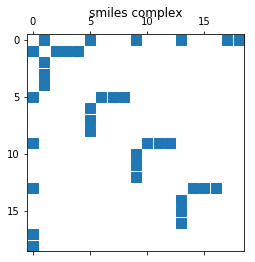

In [39]:
SMILEs_strings = ['[NH3]','[I-]']
ligs = [SMILEs_to_liglist(s,[0]) for s in SMILEs_strings]
metal_mol = mol3D()
metal_mol.addAtom(atom3D("Fe")) 

start_time = time.time()
## let's make the eq NH3 ax I- complex
eq_ligs = 4*[ligs[0]]
ax_ligs = 2*[ligs[1]]
eq_cons = 4*[[0]]
ax_cons = 2*[[0]]
custom_ligand_dict = {"eq_ligand_list":eq_ligs,
                      "ax_ligand_list":ax_ligs,
                      "eq_con_int_list":eq_cons,
                      "ax_con_int_list":ax_cons}
this_complex = assemble_connectivity_from_parts(metal_mol,custom_ligand_dict)
con_mat  = this_complex.graph  
descriptor_names, descriptors = get_descriptor_vector(this_complex,custom_ligand_dict)
new_time = (time.time() - start_time)
print("--- %s seconds ---" % new_time)
plt.spy(con_mat,precision=0.01, markersize=10)
plt.title('smiles complex')
plt.show()


--- 0.14081287384 seconds ---


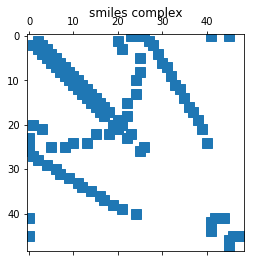

In [40]:
SMILEs_strings = ['c1cc2cc3ccc(cc4ccc(cc5ccc(cc1n2)[nH]5)n4)[nH]3','[NH3]']
ligs = [SMILEs_to_liglist(s,[0]) for s in SMILEs_strings]
metal_mol = mol3D()
metal_mol.addAtom(atom3D("Fe")) 

start_time = time.time()
## let's make the eq NH3 ax I- complex
eq_ligs = 1*[ligs[0]]
ax_ligs = 2*[ligs[1]]
eq_cons = 1*[[22,23,24,25]]
ax_cons = 2*[[0]]
custom_ligand_dict = {"eq_ligand_list":eq_ligs,
                      "ax_ligand_list":ax_ligs,
                      "eq_con_int_list":eq_cons,
                      "ax_con_int_list":ax_cons}
this_complex = assemble_connectivity_from_parts(metal_mol,custom_ligand_dict)
con_mat  = this_complex.graph  
descriptor_names, descriptors = get_descriptor_vector(this_complex,custom_ligand_dict)
new_time = (time.time() - start_time)
print("--- %s seconds ---" % new_time)
plt.spy(con_mat,precision=0.01, markersize=10)
plt.title('smiles complex')
plt.show()
